In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import network_dynamics as ndyn

# Simulation #1 - Fully connected, Gaussian Kernel

We're looking to see that global inhibition is working, that eventually firing rates plateau when there is no longer external input.

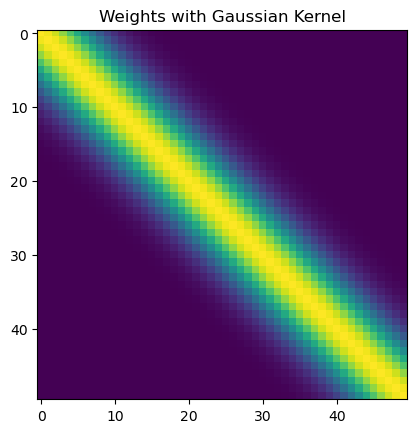

In [61]:
network = ndyn.Network(N=50, T=20)
ndyn.plot_weight_matrix(network, 'Weights with Gaussian Kernel')

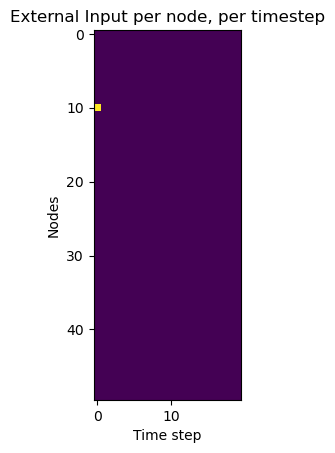

In [62]:
external_input = np.zeros((num_nodes, num_time_steps))
external_input[10, 0] = 1

ndyn.plot_external_input(external_input)

In [70]:
solution = network.simulate(external_input, ndyn.sp_solve_ivp)
print(solution)

KeyError: 'T'

AttributeError: 'NoneType' object has no attribute 'y'

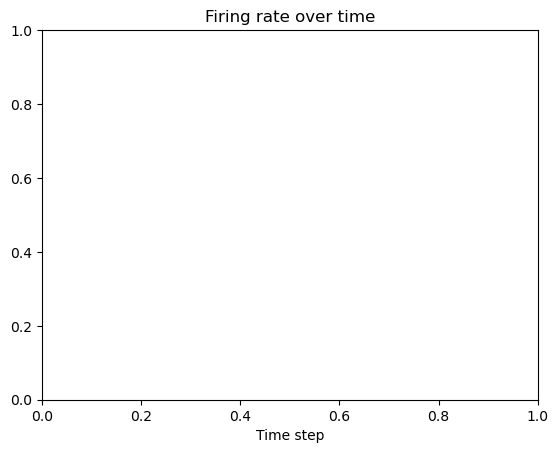

In [67]:
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.imshow(solution.y)
# plt.plot(solution.t, solution.y.T);

# Simulation #2 - "Flashing" external input with strong recurrent weight

We're looking to see that

In [ ]:
# np.fill_diagonal(network.W, 3)

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation." (Wu & Amari 2005)

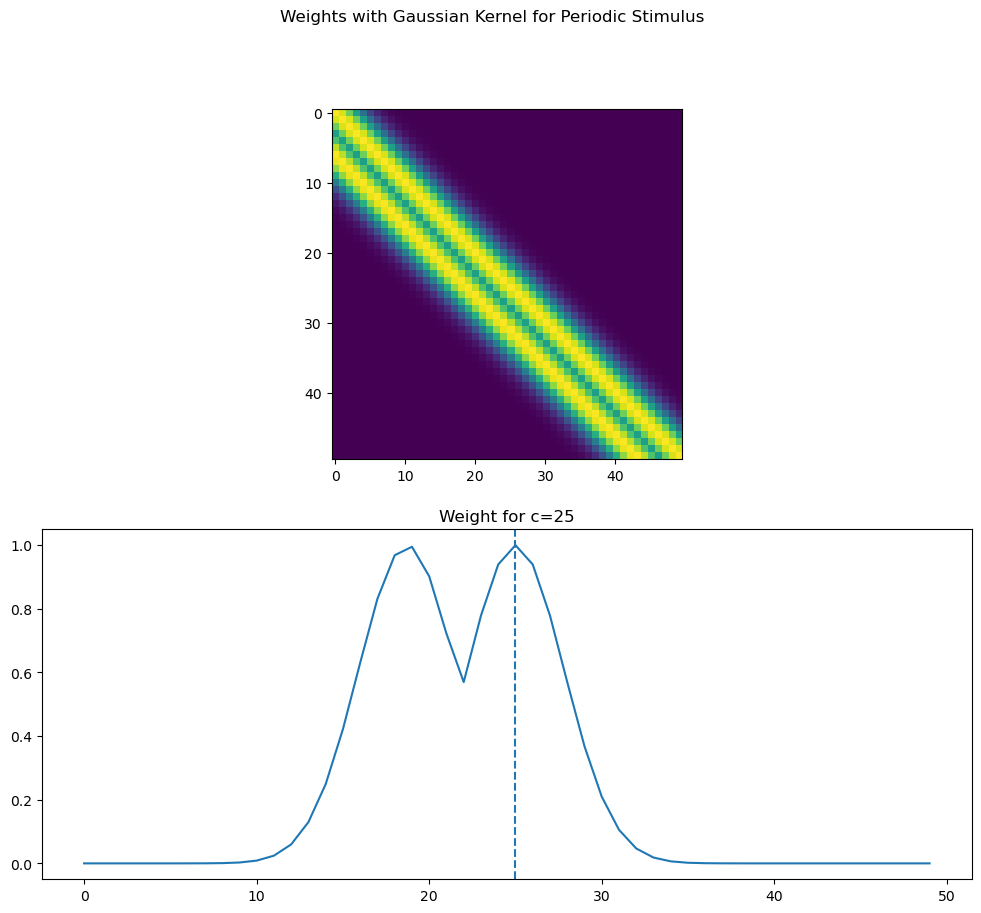

In [17]:
num_nodes = 50
num_time_steps = 20

w = np.zeros((num_nodes, num_nodes))
width = 2
for r in range(1, num_nodes + 1):
    for c in range(1, num_nodes + 1):
        if r - c <= math.pi:
            w[r - 1][c - 1] = math.exp(-math.pow(r - c, 2) / (2 * width * math.pow(width, 2)))
        else:
            w[r - 1][c - 1] = math.exp(-math.pow(2 * math.pi - math.fabs(r - c), 2) / (2 * width * math.pow(width, 2)))

plotted_weight_index = 25
fig, axs = plt.subplots(2, figsize=(12, 10))
fig.suptitle('Weights with Gaussian Kernel for Periodic Stimulus')
# axs[0].plot(np.arange(num_nodes), w)
axs[0].imshow(w)
axs[1].title.set_text('Weight for c=%d' % plotted_weight_index)
axs[1].plot(np.arange(num_nodes), w[plotted_weight_index])
axs[1].axvline(plotted_weight_index, linestyle='--')
plt.show();

In [ ]:
def get_input_with_bump(neurons_to_bump: list, timestep_of_bump, N, T, a, gamma = 0.1, bump_h=2):
    external_input_with_bumps = np.tile(np.arange(N)[:, np.newaxis], (1, T))
    external_input_with_bumps = gamma * np.exp(-(external_input_with_bumps**2) / (2 * a**2))
    # TODO need to add moving bump through timesteps
    return external_input_with_bumps

external_input = get_input_with_bump(neurons_to_bump=[0, 25, 49], timestep_of_bump=3, N=num_nodes, T=num_time_steps, a=width)
# print(external_input)
plot_external_input(external_input, num_time_steps)

In [ ]:
tau = 5
mu = 5
U = np.zeros((num_nodes, num_time_steps))
Oc = U[:, 0]

solution = sp.integrate.solve_ivp(nn_ode, [0, num_time_steps - 1], U[:, 0], t_eval=np.arange(0, num_time_steps), args=(w, external_input, tau, mu))
print(solution)
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.plot(solution.t, solution.y.T);

In [ ]:
# TODOs
# use contour plot -- DONE
# critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
# generate moving input -- WIP
# h = v * t (v is speed) -- WIP
# add noise from 2020 bioxiv paper
